# **Downloading Dataset from Kaggle**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install kaggle

In [ ]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d zippyz/cats-and-dogs-breeds-classification-oxford-dataset

100% 780M/780M [00:05<00:00, 152MB/s]
100% 780M/780M [00:05<00:00, 141MB/s]


In [ ]:
!unzip cats-and-dogs-breeds-classification-oxford-dataset.zip

Streaming output truncated to the last 5000 lines.
  inflating: images/images/Sphynx_9.jpg  
  inflating: images/images/Sphynx_90.jpg  
  inflating: images/images/Sphynx_91.jpg  
  inflating: images/images/Sphynx_92.jpg  
  inflating: images/images/Sphynx_93.jpg  
  inflating: images/images/Sphynx_94.jpg  
  inflating: images/images/Sphynx_95.jpg  
  inflating: images/images/Sphynx_96.jpg  
  inflating: images/images/Sphynx_98.jpg  
  inflating: images/images/Sphynx_99.jpg  
  inflating: images/images/american_bulldog_10.jpg  
  inflating: images/images/american_bulldog_100.jpg  
  inflating: images/images/american_bulldog_101.jpg  
  inflating: images/images/american_bulldog_102.jpg  
  inflating: images/images/american_bulldog_103.jpg  
  inflating: images/images/american_bulldog_104.jpg  
  inflating: images/images/american_bulldog_105.jpg  
  inflating: images/images/american_bulldog_106.jpg  
  inflating: images/images/american_bulldog_107.jpg  
  inflating: images/images/american

In [ ]:
!cp /content/drive/MyDrive/FYP/cats_breed_dataset.zip /content/

In [ ]:
!unzip /content/cats_breed_dataset.zip

Streaming output truncated to the last 5000 lines.
  inflating: __MACOSX/cats breed dataset1/annotations/annotations/trimaps/._Bengal_35.png  
  inflating: cats breed dataset1/annotations/annotations/trimaps/havanese_140.png  
  inflating: __MACOSX/cats breed dataset1/annotations/annotations/trimaps/._havanese_140.png  
  inflating: cats breed dataset1/annotations/annotations/trimaps/Bengal_21.png  
  inflating: __MACOSX/cats breed dataset1/annotations/annotations/trimaps/._Bengal_21.png  
  inflating: cats breed dataset1/annotations/annotations/trimaps/samoyed_22.png  
  inflating: __MACOSX/cats breed dataset1/annotations/annotations/trimaps/._samoyed_22.png  
  inflating: cats breed dataset1/annotations/annotations/trimaps/havanese_154.png  
  inflating: __MACOSX/cats breed dataset1/annotations/annotations/trimaps/._havanese_154.png  
  inflating: cats breed dataset1/annotations/annotations/trimaps/leonberger_158.png  
  inflating: __MACOSX/cats breed dataset1/annotations/annotations

# **Imports and Pre-processing Dataset**

In [ ]:
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
strategy = tf.distribute.MirroredStrategy()

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)


In [ ]:
batch_size = 32
GLOBAL_BATCH_SIZE= batch_size * strategy.num_replicas_in_sync
train_data = ImageDataGenerator(preprocessing_function=preprocess_input).flow_from_directory(
    '/content/cats breed dataset/images/train',
    target_size=(224,224),
    batch_size=GLOBAL_BATCH_SIZE,
)

Found 1632 images belonging to 12 classes.


In [ ]:
validation_data = ImageDataGenerator(preprocessing_function=preprocess_input).flow_from_directory(
    '/content/cats breed dataset/images/validation',
    target_size=(224,224),
    batch_size=GLOBAL_BATCH_SIZE,
)

Found 768 images belonging to 12 classes.


In [ ]:
with strategy.scope():
  mobilenet_model = MobileNetV2(weights='imagenet', include_top=False)
  x = mobilenet_model.output
  x = GlobalAveragePooling2D()(x)
  x = Dense(512, activation='relu')(x)
  x = Dense(256, activation='relu')(x)
  x = Dense(128, activation='relu')(x)
  y = Dense(12, activation='softmax')(x)

  model = Model(inputs=mobilenet_model.input, outputs=y)
  for layer in model.layers[:-5]:
    layer.trainable=False
  
  epochs = 10
  model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=5e-05), metrics=['accuracy'])

history = model.fit(train_data, validation_data=validation_data,epochs=epochs)

INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Redu

# **Distributed Training**

In [ ]:
with strategy.scope():
  mobilenet_model = MobileNetV2(weights='imagenet', include_top=False)
  x = mobilenet_model.output
  x = GlobalAveragePooling2D()(x)
  x = Dense(512, activation='relu')(x)
  x = Dense(256, activation='relu')(x)
  x = Dense(128, activation='relu')(x)
  y = Dense(12, activation='softmax')(x)

  model = Model(inputs=mobilenet_model.input, outputs=y)
  for layer in model.layers[:-5]:
    layer.trainable=False
  
  epochs = 10
  model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=5e-05), metrics=['accuracy'])

history = model.fit(train_data, validation_data=validation_data,epochs=epochs)

# **Build Model and adding custom layers**

In [ ]:
with strategy.scope():
  mobilenet_model = MobileNetV2(weights='imagenet', include_top=False)
  x = mobilenet_model.output
  x = GlobalAveragePooling2D()(x)
  x = Dense(512, activation='relu')(x)
  x = Dense(256, activation='relu')(x)
  x = Dense(128, activation='relu')(x)
  y = Dense(12, activation='softmax')(x)

  model = Model(inputs=mobilenet_model.input, outputs=y)
  for layer in model.layers[:-5]:
    layer.trainable=False
  
  epochs = 10
  model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=5e-05), metrics=['accuracy'])

history = model.fit(train_data, validation_data=validation_data,epochs=epochs)

9420800/9406464 [==============================] - 0s 0us/step
Epoch 1/10
44/44 [==============================] - 95s 2s/step - loss: 2.2738 - accuracy: 0.2651 - val_loss: 2.0103 - val_accuracy: 0.4844
Epoch 2/10
44/44 [==============================] - 69s 2s/step - loss: 1.6478 - accuracy: 0.6721 - val_loss: 1.4624 - val_accuracy: 0.6276
Epoch 3/10
44/44 [==============================] - 86s 2s/step - loss: 1.0600 - accuracy: 0.7969 - val_loss: 1.0105 - val_accuracy: 0.7500
Epoch 4/10
44/44 [==============================] - 68s 2s/step - loss: 0.6707 - accuracy: 0.8781 - val_loss: 0.7707 - val_accuracy: 0.7956
Epoch 5/10
44/44 [==============================] - 85s 2s/step - loss: 0.4639 - accuracy: 0.9095 - val_loss: 0.6451 - val_accuracy: 0.8047
Epoch 6/10
44/44 [==============================] - 86s 2s/step - loss: 0.3534 - accuracy: 0.9316 - val_loss: 0.5972 - val_accuracy: 0.8086
Epoch 7/10
44/44 [==============================] - 68s 2s/step - loss: 0.2795 - accuracy: 0.9444

In [ ]:
mobilenet_model = MobileNetV2(weights='imagenet', include_top=False)
x = mobilenet_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dense(256, activation='relu')(x)
x = Dense(128, activation='relu')(x)
y = Dense(12, activation='softmax')(x)

model = Model(inputs=mobilenet_model.input, outputs=y)

In [ ]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 Conv1 (Conv2D)                 (None, None, None,   864         ['input_2[0][0]']                
                                32)                                                               
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, None, None,   128         ['Conv1[0][0]']                  
                                32)                                                         

In [ ]:
for layer in model.layers[:-5]:
  layer.trainable=False

model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 Conv1 (Conv2D)                 (None, None, None,   864         ['input_2[0][0]']                
                                32)                                                               
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, None, None,   128         ['Conv1[0][0]']                  
                                32)                                                         

# **Training**

In [ ]:
epochs = 10

model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=5e-05), metrics=['accuracy'])

In [ ]:
history = model.fit(train_data, validation_data=validation_data,epochs=epochs)

Epoch 1/10
44/44 [==============================] - 18s 343ms/step - loss: 2.2145 - accuracy: 0.3229 - val_loss: 1.9186 - val_accuracy: 0.5221
Epoch 2/10
44/44 [==============================] - 14s 321ms/step - loss: 1.5441 - accuracy: 0.6579 - val_loss: 1.3063 - val_accuracy: 0.6914
Epoch 3/10
44/44 [==============================] - 14s 327ms/step - loss: 0.9568 - accuracy: 0.8297 - val_loss: 0.8627 - val_accuracy: 0.7865
Epoch 4/10
44/44 [==============================] - 14s 324ms/step - loss: 0.6026 - accuracy: 0.8795 - val_loss: 0.6493 - val_accuracy: 0.8281
Epoch 5/10
44/44 [==============================] - 15s 331ms/step - loss: 0.4312 - accuracy: 0.9031 - val_loss: 0.5590 - val_accuracy: 0.8307
Epoch 6/10
44/44 [==============================] - 14s 319ms/step - loss: 0.3316 - accuracy: 0.9287 - val_loss: 0.5289 - val_accuracy: 0.8385
Epoch 7/10
44/44 [==============================] - 14s 315ms/step - loss: 0.2697 - accuracy: 0.9465 - val_loss: 0.5051 - val_accuracy: 0.8411

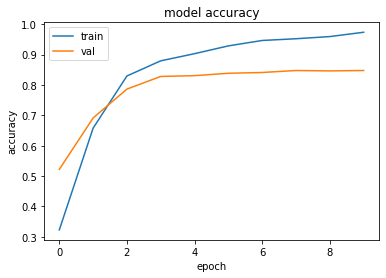

In [ ]:
from matplotlib import pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

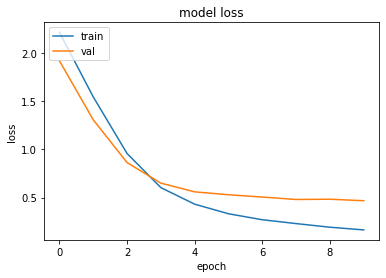

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
from keras.preprocessing.image import load_img, img_to_array
#from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
def runprediction(file):
  #load the image
  my_image = load_img(file, target_size=(224, 224))

  #preprocess the image
  my_image = img_to_array(my_image)
  my_image = my_image.reshape((1, my_image.shape[0], my_image.shape[1], my_image.shape[2]))
  my_image = preprocess_input(my_image)

  #make the prediction
  prediction = model.predict(my_image)
  return prediction

In [ ]:
import numpy as np
[np.round(x) for x in prediction]

[array([0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)]

In [ ]:
import os
def get_file_size(file_path):
  size = os.path.getsize(file_path)
  size = 'File size : ' + str(round(size/(1024*1024),3)) + "MB"
  return size

In [ ]:
model.save('cat_breeds_model_new.h5')

In [ ]:
get_file_size('cat_breeds_model_new.h5')

'File size : 18.502MB'

# **Saving**

In [ ]:
tf.saved_model.save(model, '/content/modell')

INFO:tensorflow:Assets written to: /content/modell/assets


# **Converting Tenorflow to Tensorflow Lite**

In [ ]:
import tensorflow as tf
converter = tf.lite.TFLiteConverter.from_keras_model(model) # Your model's name
tfmodel = converter.convert()
file = open( 'cats_breed_model_new.tflite' , 'wb' ) 
file.write( tfmodel )

INFO:tensorflow:Assets written to: /tmp/tmpoxmqu7nc/assets


12147040

In [ ]:
get_file_size('/content/cats_breed_model_new.tflite')

'File size : 11.584MB'

In [ ]:
!cp /content/cat_breeds_model_new.h5 /content/drive/MyDrive/FYP/

cp: cannot stat '/content/cat_breeds_model_new.h5': No such file or directory


In [ ]:
import tensorflow as tf
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.target_spec.supported_types = [tf.float32]
tflite_quant_model = converter.convert()
file = open( 'cats_breed_model_quant.tflite' , 'wb' ) 
file.write(tflite_quant_model)

INFO:tensorflow:Assets written to: /tmp/tmpgcqyh0b8/assets


INFO:tensorflow:Assets written to: /tmp/tmpgcqyh0b8/assets


12147040

# **Load**

In [ ]:
import tensorflow as tf
model = tf.keras.models.load_model('/content/drive/MyDrive/FYP/cat_breeds_model_new.h5')

In [ ]:
model.evaluate(train_data)

44/44 [==============================] - 7s 163ms/step - loss: 0.1413 - accuracy: 0.9815


[0.14129571616649628, 0.9814682602882385]

In [ ]:
model.evaluate(validation_data)

24/24 [==============================] - 4s 167ms/step - loss: 0.4668 - accuracy: 0.8477


[0.4667953550815582, 0.84765625]

# **Misc**

In [ ]:
import tensorflow as tf
image_data_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    featurewise_center=False,
    samplewise_center=False,
    featurewise_std_normalization=False,
    samplewise_std_normalization=False,
    zca_whitening=False,
    zca_epsilon=1e-06,
    rotation_range=0,
    width_shift_range=0.0,
    height_shift_range=0.0,
    brightness_range=None,
    shear_range=0.0,
    zoom_range=0.0,
    channel_shift_range=0.0,
    fill_mode='nearest',
    cval=0.0,
    horizontal_flip=False,
    vertical_flip=False,
    rescale=None,
    preprocessing_function=None,
    data_format=None,
    validation_split=0.0,
    dtype=None
)
train_data = tf.keras.preprocessing.image.DirectoryIterator(
    '/content/cats breed dataset/images/train',
    image_data_generator,
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
)

Found 1403 images belonging to 12 classes.


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications import imagenet_utils
from sklearn.metrics import confusion_matrix
from IPython.display import Image

In [ ]:
model = tf.keras.applications.MobileNetV2()

14548992/14536120 [==============================] - 0s 0us/step


In [ ]:
model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                              

In [ ]:
def prepare_image(file):
    #img_path = '/content/dataset/images/Abyssinian/'
    img = image.load_img( file, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array_expanded_dims = np.expand_dims(img_array, axis=0)
    return tf.keras.applications.mobilenet_v2.preprocess_input(img_array_expanded_dims)

In [ ]:
preprocessed_image = prepare_image('/content/images/images/Bengal_120.jpg')
predictions = model.predict(preprocessed_image)

In [ ]:
results = imagenet_utils.decode_predictions(predictions)
results

[[('n02124075', 'Egyptian_cat', 0.41903576),
  ('n02123045', 'tabby', 0.28454524),
  ('n04493381', 'tub', 0.18512781),
  ('n02808440', 'bathtub', 0.050150696),
  ('n02123159', 'tiger_cat', 0.018915659)]]

# **API**

In [ ]:
!pip install fastapi
!pip install pyngrok
!pip install uvicorn
!pip install python-multipart
!ngrok authtoken 24mtgv4i7ag48f3ZgX1Zpn6i3qB_MxUtXocX2pxuoetECZif

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 54 kB 2.0 MB/s 
     |████████████████████████████████| 63 kB 2.0 MB/s 
     |████████████████████████████████| 11.1 MB 31.4 MB/s 
     |████████████████████████████████| 80 kB 9.5 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 745 kB 5.0 MB/s 
  Created wheel for pyngrok: filename=pyngrok-5.1.0-py3-none-any.whl size=19007 sha256=3eb6bce64738837e80b570a5e81a2b3860c6cc5021fee7a37d9d17227afea11d
  Stored in directory: /root/.cache/pip/wheels/bf/e6/af/ccf6598ecefecd44104069371795cb9b3afbcd16987f6ccfb3
Successfully built pyngrok
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 53 kB 1.5 MB/s 
     |████████████████████████████████| 58 kB 6.0 MB/s 
Looking in indexes: h

In [ ]:
from fastapi import FastAPI, File, UploadFile
from fastapi.responses import FileResponse
import nest_asyncio
from pyngrok import ngrok
import uvicorn
import numpy as np
import os

from PIL import Image
from io import BytesIO
import matplotlib.pyplot as plt



app = FastAPI()

def readImage(image_encoded):
   Pil = Image.open(BytesIO(image_encoded))
   return Pil

def convert_output(argument):
    outputs = {
       0: "Abyssinian",
       1: "Bengal",
       2: "Birman",
       3: "Bombay",
       4: "British Shorthair",
       5: "Egyptian Mau",
       6: "Maine Coon",
       7: "Persian",
       8: "Ragdoll",
       9: "Russian Blue",
       10: "Siamese",
       11: "Sphynx",
    }
 
    # get() method of dictionary data type returns
    # value of passed argument if it is present
    # in dictionary otherwise second argument will
    # be assigned as default value of passed argument
    return outputs.get(argument)

@app.post("/classifycat/")
async def classify(img_input: UploadFile = File(...)):
    img_input = readImage(await img_input.read())
    img_input.save("/content/img_input.png")
    preds = runprediction("/content/img_input.png")
    output = convert_output(int(np.argmax(preds)))
    accuracy = np.max(preds)*100
    return {"output": output, "accuracy": accuracy}
    
   

@app.get('/index')
async def home():
  return "Hello World"

ngrok_tunnel = ngrok.connect(8000)
print('Public URL:', ngrok_tunnel.public_url)
nest_asyncio.apply()
uvicorn.run(app, port=8000)

Public URL: http://d91b-104-196-160-98.ngrok.io


INFO:     Started server process [63]
INFO:     Waiting for application startup.
INFO:     Application startup complete.
INFO:     Uvicorn running on http://127.0.0.1:8000 (Press CTRL+C to quit)
